## Pipeline for heart disease data - Revisited

Instead of dropping columns and filling NaN when loading, we will keep all columns and leave NaN in. We can use `SimpleImputer()` to replace the missing values with a statistical metric.

In the pipeline:
- For numeric features we impute with median using `SimpleImputer()` and apply standard scaling
- For categorical features we impute with most frequent using `SimpleImputer()` and apply one-hot encoding

We could call this a *minimal information* imputation. The model does not get much information from median and most frequent values. These rows will blend in.

We will find that previously dropped features  `['slope', 'ca', 'thal']` do have large logistic regression coefficients and seem to be useful.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import mglearn

In [3]:
def load_heart_disease():
    '''Load and pre-process heart disease data
    
    if processed.hungarian.data file is not present.
    
    it will be downloaded from
    https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.hungarian.data
    
    return: data(DataFrame)
    
    '''
    
    import os
    import requests
    
    
    file_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.hungarian.data'
    file_name = file_url.split('/')[-1]
    
    if not os.path.isfile(file_name):
        print('Downloading from {}'.format(file_url))
        r = requests.get(file_url)
        with open(file_name,'wb') as output_file:
            output_file.write(r.content)
        
    data = pd.read_csv(file_name, 
                   na_values='?', 
                   names=[ 'age', 'sex', 'cp', 'trestbps', 'chol', 'fbs',
                            'restecg', 'thalach', 'exang', 'oldpeak', 'slope',
                            'ca', 'thal', 'num'])
    
    
    return data

In [4]:
data = load_heart_disease()

In [5]:
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,28,1,2,130.0,132.0,0.0,2.0,185.0,0.0,0.0,NaN,NaN,NaN,0
1,29,1,2,120.0,243.0,0.0,0.0,160.0,0.0,0.0,NaN,NaN,NaN,0
2,29,1,2,140.0,NaN,0.0,0.0,170.0,0.0,0.0,NaN,NaN,NaN,0
3,30,0,1,170.0,237.0,0.0,1.0,170.0,0.0,0.0,NaN,NaN,6.0,0
4,31,0,2,100.0,219.0,0.0,1.0,150.0,0.0,0.0,NaN,NaN,NaN,0


### What are the column data types?

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294 entries, 0 to 293
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       294 non-null    int64  
 1   sex       294 non-null    int64  
 2   cp        294 non-null    int64  
 3   trestbps  293 non-null    float64
 4   chol      271 non-null    float64
 5   fbs       286 non-null    float64
 6   restecg   293 non-null    float64
 7   thalach   293 non-null    float64
 8   exang     293 non-null    float64
 9   oldpeak   294 non-null    float64
 10  slope     104 non-null    float64
 11  ca        3 non-null      float64
 12  thal      28 non-null     float64
 13  num       294 non-null    int64  
dtypes: float64(10), int64(4)
memory usage: 32.3 KB


### Fixing data types

In [7]:
data = data.astype({col: 'category' for col in [ 'sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']})
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294 entries, 0 to 293
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   age       294 non-null    int64   
 1   sex       294 non-null    category
 2   cp        294 non-null    category
 3   trestbps  293 non-null    float64 
 4   chol      271 non-null    float64 
 5   fbs       286 non-null    category
 6   restecg   293 non-null    category
 7   thalach   293 non-null    float64 
 8   exang     293 non-null    category
 9   oldpeak   294 non-null    float64 
 10  slope     104 non-null    category
 11  ca        3 non-null      category
 12  thal      28 non-null     category
 13  num       294 non-null    int64   
dtypes: category(8), float64(4), int64(2)
memory usage: 17.3 KB


### What kind of values do columns have?

In [8]:
for col in data.columns:
    print(col)
    print(data[col].unique() )
    print()

age
[28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51
 52 53 54 55 56 57 58 59 60 61 62 63 65 66]

sex
[1, 0]
Categories (2, int64): [0, 1]

cp
[2, 1, 3, 4]
Categories (4, int64): [1, 2, 3, 4]

trestbps
[130. 120. 140. 170. 100. 105. 110. 125. 150.  98. 112. 145. 190. 160.
 115. 142. 180. 132. 135.  nan 108. 124. 113. 122.  92. 118. 106. 200.
 138. 136. 128. 155.]

chol
[132. 243.  nan 237. 219. 198. 225. 254. 298. 161. 214. 220. 160. 167.
 308. 264. 166. 340. 209. 260. 211. 173. 283. 194. 223. 315. 275. 297.
 292. 182. 200. 204. 241. 339. 147. 273. 307. 289. 215. 281. 250. 184.
 245. 291. 295. 269. 196. 268. 228. 358. 201. 249. 266. 186. 207. 218.
 412. 224. 238. 230. 163. 240. 280. 257. 263. 276. 284. 195. 227. 253.
 187. 202. 328. 168. 216. 129. 190. 188. 179. 210. 272. 180. 100. 259.
 468. 274. 320. 221. 309. 312. 171. 208. 246. 305. 217. 365. 344. 394.
 256. 326. 277. 270. 229.  85. 347. 251. 222. 287. 318. 213. 294. 193.
 271. 156. 267. 282. 117. 466. 247. 

### A closer look at previously dropped features `['slope', 'ca', 'thal']` 

In [9]:
for col in ['slope', 'ca', 'thal']:
    print(data[col].value_counts())
    print()

slope
2.0    91
1.0    12
3.0     1
Name: count, dtype: int64

ca
0.0    3
Name: count, dtype: int64

thal
7.0    11
6.0    10
3.0     7
Name: count, dtype: int64



### Setting up the pipeline

For numerical features we impute with median and apply standard scaling.

For categorical features we impute with most frequent and apply one-hot encoding.

In [10]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression



numeric_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = [ 'sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
pipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression(max_iter=1000))])

### Splitting the data

In [11]:
from sklearn.model_selection import train_test_split
# get all columns apart from income for the features
X = data.drop(columns='num')
y = data['num']
print(X.shape)
print(y.shape)

# split dataframe and income
X_train, X_test, y_train, y_test = train_test_split(X, y,
                            test_size=0.1, stratify=y,random_state=31)



(294, 13)
(294,)


### Grid search 

In [12]:
from sklearn.model_selection import GridSearchCV

param_grid = {'classifier__C': [0.1, 1.0, 10.0, 100.0],
             'classifier__fit_intercept': [True, False]}
grid = GridSearchCV(pipe, param_grid, cv=5, return_train_score=True)



In [13]:
grid.fit(X_train, y_train)

print("Best params:\n{}\n".format(grid.best_params_))
print("Best cross-validation train score: {:.2f}".format(grid.cv_results_['mean_train_score'][grid.best_index_]))
print("Best cross-validation validation score: {:.2f}".format(grid.best_score_))

Best params:
{'classifier__C': 10.0, 'classifier__fit_intercept': False}

Best cross-validation train score: 0.87
Best cross-validation validation score: 0.85


### Visualize model coefficients

In [14]:
grid.best_estimator_['preprocessor']


ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['age', 'trestbps', 'chol', 'thalach',
                                  'oldpeak']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['sex', 'cp', 'fbs', 'restecg', 'exang',
                                  'slope', 'ca', 'thal'])])

In [15]:
processed_feature_names = numeric_features +\
                        grid.best_estimator_['preprocessor'].transformers_[1][1]['onehot']\
                           .get_feature_names_out(categorical_features).tolist()
processed_feature_names

['age',
 'trestbps',
 'chol',
 'thalach',
 'oldpeak',
 'sex_0.0',
 'sex_1.0',
 'cp_1.0',
 'cp_2.0',
 'cp_3.0',
 'cp_4.0',
 'fbs_0.0',
 'fbs_1.0',
 'restecg_0.0',
 'restecg_1.0',
 'restecg_2.0',
 'exang_0.0',
 'exang_1.0',
 'slope_1.0',
 'slope_2.0',
 'slope_3.0',
 'ca_0.0',
 'thal_3.0',
 'thal_6.0',
 'thal_7.0']

Text(0, 0.5, 'Coefficient magnitude')

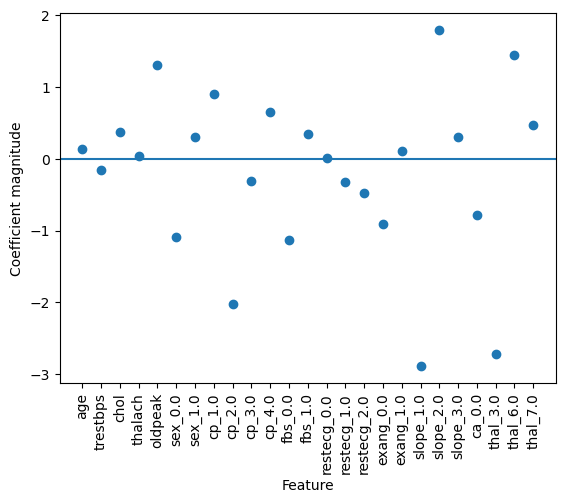

In [16]:
plt.plot(grid.best_estimator_['classifier'].coef_.T, 'o')

plt.xticks(range(len(processed_feature_names)), processed_feature_names, rotation=90)
xlims = plt.xlim()
plt.hlines(0, xlims[0], xlims[1])
plt.xlim(xlims)
# plt.ylim(-5, 5)
plt.xlabel("Feature")
plt.ylabel("Coefficient magnitude")
# plt.legend()

Note: previsouly dropped features  `['slope', 'ca', 'thal']` do have large coefficients and seem to be important.

### Retrain best model and print test set performance

In [17]:
model = grid.best_estimator_
model.fit(X_train, y_train)
print("Test-set score: {:.2f}".format(model.score(X_test, y_test)))

Test-set score: 0.90


## What if we impute with an out-of-range value?

When we choose an out-of-range value for imputation, the model has a chance to learn from these missing values. Maybe there is a reason values are missing that relates to the prediction.

In [18]:
#TODO: recreate pipeline changing SimpleImputer() to strategy-constant with fill_value=-1

numeric_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=-1)),
    ('scaler', StandardScaler())])

categorical_features = [ 'sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=-1)),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
pipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression(max_iter=1000))])

In [19]:
#TODO: Re-create the parameter grid and GridSearchCV object
param_grid = {'classifier__C': [0.1, 1.0, 10.0, 100.0],
             'classifier__fit_intercept': [True, False]}
grid = GridSearchCV(pipe, param_grid, cv=5, return_train_score=True)

In [20]:
#TODO: perform grid search
grid.fit(X_train, y_train)

print("Best params:\n{}\n".format(grid.best_params_))
print("Best cross-validation train score: {:.2f}".format(grid.cv_results_['mean_train_score'][grid.best_index_]))
print("Best cross-validation validation score: {:.2f}".format(grid.best_score_))

Best params:
{'classifier__C': 1.0, 'classifier__fit_intercept': True}

Best cross-validation train score: 0.87
Best cross-validation validation score: 0.86


In [21]:
#TODO: get the processed feature names
processed_feature_names = numeric_features +\
                        grid.best_estimator_['preprocessor'].transformers_[1][1]['onehot']\
                           .get_feature_names_out(categorical_features).tolist()
processed_feature_names

['age',
 'trestbps',
 'chol',
 'thalach',
 'oldpeak',
 'sex_0.0',
 'sex_1.0',
 'cp_1.0',
 'cp_2.0',
 'cp_3.0',
 'cp_4.0',
 'fbs_-1.0',
 'fbs_0.0',
 'fbs_1.0',
 'restecg_0.0',
 'restecg_1.0',
 'restecg_2.0',
 'exang_-1.0',
 'exang_0.0',
 'exang_1.0',
 'slope_-1.0',
 'slope_1.0',
 'slope_2.0',
 'slope_3.0',
 'ca_-1.0',
 'ca_0.0',
 'thal_-1.0',
 'thal_3.0',
 'thal_6.0',
 'thal_7.0']

Text(0, 0.5, 'Coefficient magnitude')

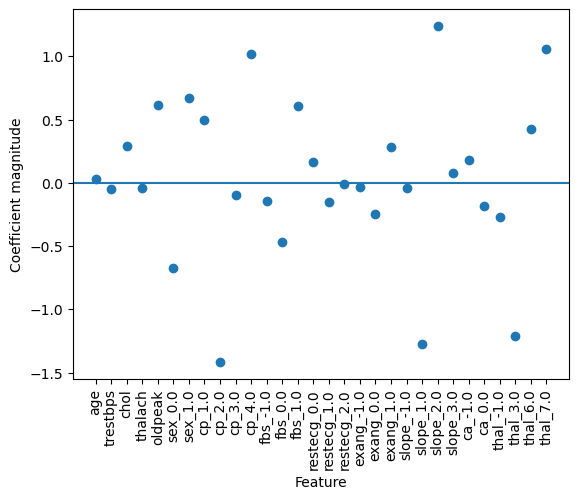

In [22]:
#TODO: Plot the coefficients
plt.plot(grid.best_estimator_['classifier'].coef_.T, 'o')

plt.xticks(range(len(processed_feature_names)), processed_feature_names, rotation=90)
xlims = plt.xlim()
plt.hlines(0, xlims[0], xlims[1])
plt.xlim(xlims)
# plt.ylim(-5, 5)
plt.xlabel("Feature")
plt.ylabel("Coefficient magnitude")
# plt.legend()

The `-1.0` features do not seem to have large coefficients. Therefore, missing values do not seem to carry important information.

### Retrain best model and print test set performance

In [23]:
model = grid.best_estimator_
model.fit(X_train, y_train)
print("Test-set score: {:.2f}".format(model.score(X_test, y_test)))

Test-set score: 0.80


## Conclusion

The *minimal information* imputation gave us accuracies of:
- CV(5) Train 87%
- CV(5) Valid 85%
- Test 90%

The *out-of-range* imputation gave us accuracies of:
- CV(5) Train 87%
- CV(5) Valid 86%
- Test 80%

Since we only look at the test set at the very end, we would choose the *out-of-range* pipeline here, because it has the larger validation score, and report to the customer that the expected accuracy in production is 80%.

Remember:
- we used 10% in the test set with random_seed=31
- we used cv=5

Would it look different for different choices?